In [1]:
import sys
sys.path.append("../Modules/")
sys.path.append("../pyFiles/")
sys.path.append("../")
import os

import pandas as pd
import numpy as np

    
import logging

fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import os

init_notebook_mode(connected=True)


In [2]:
# sessionDict = projectTrajectories(sessionDict)
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
import pickle

file = open('../sessionFiles.pickle', 'rb')
allSessions = pickle.load(file)
file.close()

sessionDict = allSessions[0]

In [4]:
def plotMovementModel(tr,
                   trInfo,
                      analysisParameters,
                  halfHFOVDegs = 80,
                     figSize = [7,7]):
    
    import matplotlib.pyplot as plt
    
    p = plt.figure(figsize=(figSize))

    grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)
    ax = p.add_subplot(grid[:2,:2])
    ax2 = p.add_subplot(grid[2,:])
    
    ax.set(xlabel='degrees azimuth', ylabel='degrees elevation')
    ax2.set(xlabel='time (s)', ylabel='velocity (degrees)')
    
    #######
    
    # Calculate events 
    winStartTimeMs = analysisParameters['analysisWindowStart']
    winEndTimeMs = analysisParameters['analysisWindowEnd']
    interpResS = analysisParameters['interpResS']
    
    trialTime_fr = np.array(tr['frameTime'],np.float64) - np.array(tr['frameTime'],np.float64)[0]
    interpTime_s = np.arange(0,trialTime_fr[-1],interpResS)

    # Analysis should focus on the frames before ball collision or passing
    initTTC = np.float64(trInfo['ballInitialPos','z']) / -np.float64(trInfo['ballInitialVel','z'])
    endFrameIdx = np.where( trialTime_fr > initTTC )[0][0]
    lastTrajFrame = np.min([int(endFrameIdx),
               int(trInfo[('passVertPlaneAtPaddleFr', '')])])

    analysisTime_fr = np.array(tr['frameTime'],np.float64)[:lastTrajFrame] - np.array(tr['frameTime'],np.float64)[0]

    # Interpolate

    interpBallAz_s = np.interp(interpTime_s,analysisTime_fr,np.array(tr['ball_az'][:lastTrajFrame],dtype=np.float64))
    interpBallEl_s = np.interp(interpTime_s,analysisTime_fr,np.array(tr['ball_el'][:lastTrajFrame],dtype=np.float64))

    interpGazeAz_s = np.interp(interpTime_s,analysisTime_fr,np.array(tr['cycGIWFilt_az'][:lastTrajFrame],dtype=np.float64))
    interpGazeEl_s = np.interp(interpTime_s,analysisTime_fr,np.array(tr['cycGIWFilt_el'][:lastTrajFrame],dtype=np.float64))

    cycToBallVelAz_s = np.interp(interpTime_s,analysisTime_fr,np.array(tr['ballVel_az'][:lastTrajFrame],dtype=np.float64))
    cycToBallVelEl_s = np.interp(interpTime_s,analysisTime_fr,np.array(tr['ballVel_el'][:lastTrajFrame],dtype=np.float64))

    ballRadiusDegs_s = np.interp(interpTime_s,analysisTime_fr,np.array(tr['ballRadiusDegs'][:lastTrajFrame],dtype=np.float64))

    gazeVelFilt_s = np.interp(interpTime_s,analysisTime_fr,tr['gazeVelFilt'][:lastTrajFrame])

    ########################################
    #### Interpolated event times

    # Win start/end relative to initial TTC
    winStartSampleIdx = np.where( interpTime_s > initTTC + winStartTimeMs/1000.0 )[0][0]
    winEndSampleIdx = np.where( interpTime_s > initTTC + winEndTimeMs/1000.0 )[0][0] - 1

    passingTime = trialTime_fr[int(trInfo[('passVertPlaneAtPaddleFr', '')])]
    passingSampleIdx = np.where( interpTime_s > passingTime)[0][0]

    # If passing sample idx < window end, raise error
    if( passingSampleIdx < winEndSampleIdx):
        logger.warn('Ball collision occurs within analysis window!')

    # Find where the ball / gaze actually ended up
    ballWinStart_AzEl = [interpBallAz_s[winStartSampleIdx], interpBallEl_s[winStartSampleIdx]]
    ballWinEnd_AzEl = [interpBallAz_s[winEndSampleIdx], interpBallEl_s[winEndSampleIdx]]
    gazeWinStart_AzEl = [interpGazeAz_s[winStartSampleIdx], interpGazeEl_s[winStartSampleIdx]]
    gazeWinEnd_AzEl = [interpGazeAz_s[winEndSampleIdx], interpGazeEl_s[winEndSampleIdx]]
    
    
    #######
    
#     initTTC = np.float64(trInfo['ballInitialPos','Z']) / -np.float64(trInfo['ballInitialVel','Z'])
    endSampleIdx = np.where( interpTime_s > initTTC )[0][0]-1

    # Win start/end
    winStartSampleIdx = np.where( interpTime_s > initTTC + winStartTimeMs/1000.0 )[0][0]
    winEndSampleIdx = np.where( interpTime_s > initTTC + winEndTimeMs/1000.0 )[0][0] -1

    if( passingSampleIdx < winEndSampleIdx):  
        winEndSampleIdx = passingSampleIdx

    windowFr = np.arange(winStartSampleIdx,winEndSampleIdx)

    ############

    halfVFOVDegs = halfHFOVDegs / 1.77


    cList = ['r','g','b']
    lineHandles = []

    ballH = ax.plot(interpBallAz_s[:endSampleIdx],interpBallEl_s[:endSampleIdx],color='b',linewidth=3,alpha = 0.4)
    gazeH = ax.plot(interpGazeAz_s[:endSampleIdx],interpGazeEl_s[:endSampleIdx],color='r',linewidth=3,alpha = 0.4)

    from matplotlib import patches as pt

    # ax.add_patch(pt.Circle(ballAtWinEndVelPred_AzEl,radius=balllRadiusVel,
    #             fill=False,facecolor=None,ec='k',lw=3))

    ax.add_patch(pt.Circle(ballWinEnd_AzEl,radius=trInfo['ballRadiusWinEnd'],
                 fill=False,facecolor=None,ec='k',lw=3))

    ax.plot(interpBallAz_s[windowFr],interpBallEl_s[windowFr],color='b',linewidth=5, alpha = 0.6)
    ax.plot(interpGazeAz_s[windowFr],interpGazeEl_s[windowFr],color='r',linewidth=5,alpha = 0.6)

    for i in np.arange(0,len(windowFr),5):
        pf = windowFr[i]
        xs = [interpBallAz_s[pf], interpGazeAz_s[pf]]
        ys = [interpBallEl_s[pf], interpGazeEl_s[pf]]
        ax.plot(xs,ys,color='k',linewidth=1,alpha = 0.3)

    cOrM = []
    if (trInfo['isCaughtQ'].values == True):

        cOrM = ax.scatter(tr['ball_az'].iloc[lastTrajFrame-1],
                          tr['ball_el'].iloc[lastTrajFrame-1],
                          c='g',s=120,marker='8',lw=6) 
    else:

        cOrM = ax.scatter(tr['ball_az'].iloc[lastTrajFrame-1],
                          tr['ball_el'].iloc[lastTrajFrame-1],
                          c='r',s=150,marker='8',lw=6)
        
    ax.axis('equal')
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    ax.axes.yaxis.grid(True)
    ax.axes.xaxis.grid(True)
    p.set_facecolor('w')

    plt.xlim([-30,30])
    plt.ylim([-15,35])

    observedH = ax.scatter(ballWinEnd_AzEl[0],ballWinEnd_AzEl[1],c='k',s=150,marker='8')
    constantVelH = ax.scatter(trInfo['ballAtWinEndVelPred_AzEl'].values[0][0],
                              trInfo['ballAtWinEndVelPred_AzEl'].values[0][1],c='k',s=150,marker='v')
    
    gazeLoc = ax.scatter(trInfo['gazeMinDistLoc_AzEl'].values[0][0],
                         trInfo['gazeMinDistLoc_AzEl'].values[0][1],c='m',s=150,marker='x',lw=6)

    ax.text(.01,.01,str('NormLoc: {:.2}').format(trInfo['normLocInWindow'].values[0]),transform=ax.transAxes)
#     ax.text(.01,.04,str('Expansion gain: {}').format(np.float64(trInfo['expansionGain'].values)),transform=ax.transAxes)
    ax.text(.01,.07,str('Sub: {} Bl: {} Tr: {}').format(
        int(trInfo['subjectNumber']), 
        int(trInfo['blockNumber']),
        int(trInfo['trialNumber'])
    ),transform=ax.transAxes)
    
    ax.legend([gazeLoc,
               constantVelH,
               observedH,
               cOrM], 

              ['point nearest to gaze',
               'constant speed model',
               'actual displacement',
              'green=catch, red=miss'])
    

    #######################################################
    #######################################################
    ## Velocity
    
    trialTime_fr = np.array(tr['frameTime'] - tr['frameTime'].iloc[0])
    initTTC = np.float64(trInfo['ballInitialPos','z']) / -np.float64(trInfo['ballInitialVel','z'])
    winStartTimeMs = analysisParameters['analysisWindowStart']
    winEndTimeMs = analysisParameters['analysisWindowEnd']
    winStartFrameIdx = np.where( trialTime_fr > initTTC + winStartTimeMs/1000.0 )[0][0]
    winEndFrameIdx = np.where( trialTime_fr > initTTC + winEndTimeMs/1000.0 )[0][0] -1


    
    ax2.set_ylim([-100,300])
    ax2.set_xlim(trialTime_fr[winStartFrameIdx],trialTime_fr[winEndFrameIdx])
    
    gaze = ax2.plot(trialTime_fr,
            tr['gazeVelFilt']
            ,color='r',linewidth=3,alpha = .5,label='gaze')

    ballCenter = ax2.plot(trialTime_fr,
            tr['ballVel2D_fr']
            ,color='b',linewidth=3,alpha = 0.5,label='ball center')

    ballLeading = ax2.plot(trialTime_fr,
            tr['ballVelLeadingEdge']
            ,color='k',linewidth=3,alpha = 0.4,label='ball leading')

    ballTrailing = ax2.plot(trialTime_fr,
            tr['ballVelTrailingEdge']
            ,color='k',linewidth=3,alpha = 0.4,label='ball trailing')

    ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
    ax3.set_ylim([-1,1])
    ratio = ax3.plot(trialTime_fr,
            tr['gazeVelRelBallEdges']
            ,color='c',linewidth=3,alpha = 0.4,label='ratio')
    
    ax3.axhline( .5 )
    ax3.axhline( 0 )

    ax2.legend()
    ax3.legend()
    
    
    return(p,ax)




In [18]:
def saveOutVectorMovementModel(sessionDict):
    
    analysisParameters = sessionDict['analysisParameters']

    gbData_bl_tr = sessionDict['processedExp'].groupby(['blockNumber','trialNumber']) 
    gbInfo_bl_tr = sessionDict['trialInfo'].groupby(['blockNumber','trialNumber']) 


    for idx, trDataGb in gbData_bl_tr:

        blNum = np.unique(trDataGb['blockNumber'])[0]
        trNum = np.unique(trDataGb['trialNumber'])[0]

        trInfoGb = gbInfo_bl_tr.get_group((blNum,trNum)) 

        (p,ax) = plotMovementModel(trDataGb,
                      trInfoGb,
                      sessionDict['analysisParameters'],
                      halfHFOVDegs = 80,
                      figSize = [7,7])

    #     condStr = 'g-{:.1f}_pd-{:1.1f}'.format(float(trInfo['expansionGain']),float(trInfo['passingLocX']))

        condStr = 'g-{:.1f}_pd-{:1.1f}'.format(np.float64(111),np.float64(222))
        outDir = '../Figures/Projections/' + condStr + '/' + sessionDict['subID'] + '/'

        if not os.path.exists(outDir):
            os.makedirs(outDir)

        fName = str(outDir + 'b-{}_t-{}_' + condStr + '.png').format(blNum,trNum)

        plt.savefig(fName)
        plt.close()

<IPython.core.display.Javascript object>


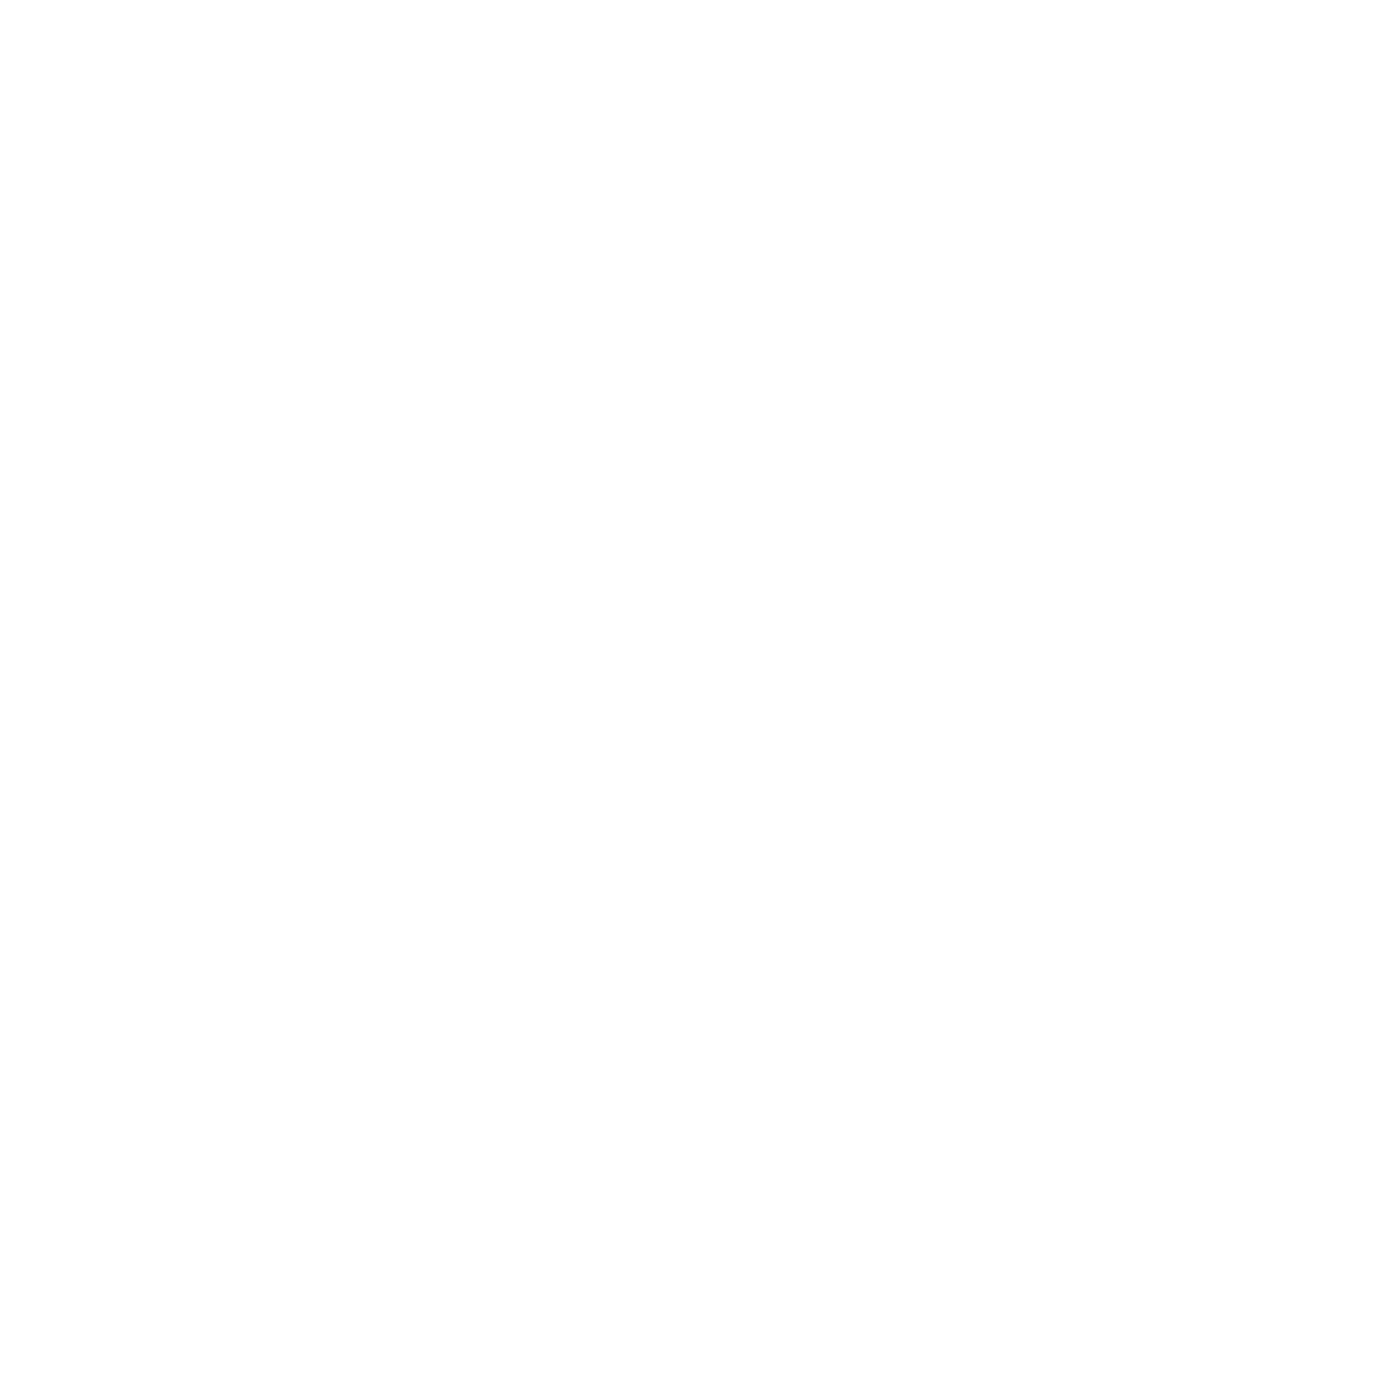

<IPython.core.display.Javascript object>


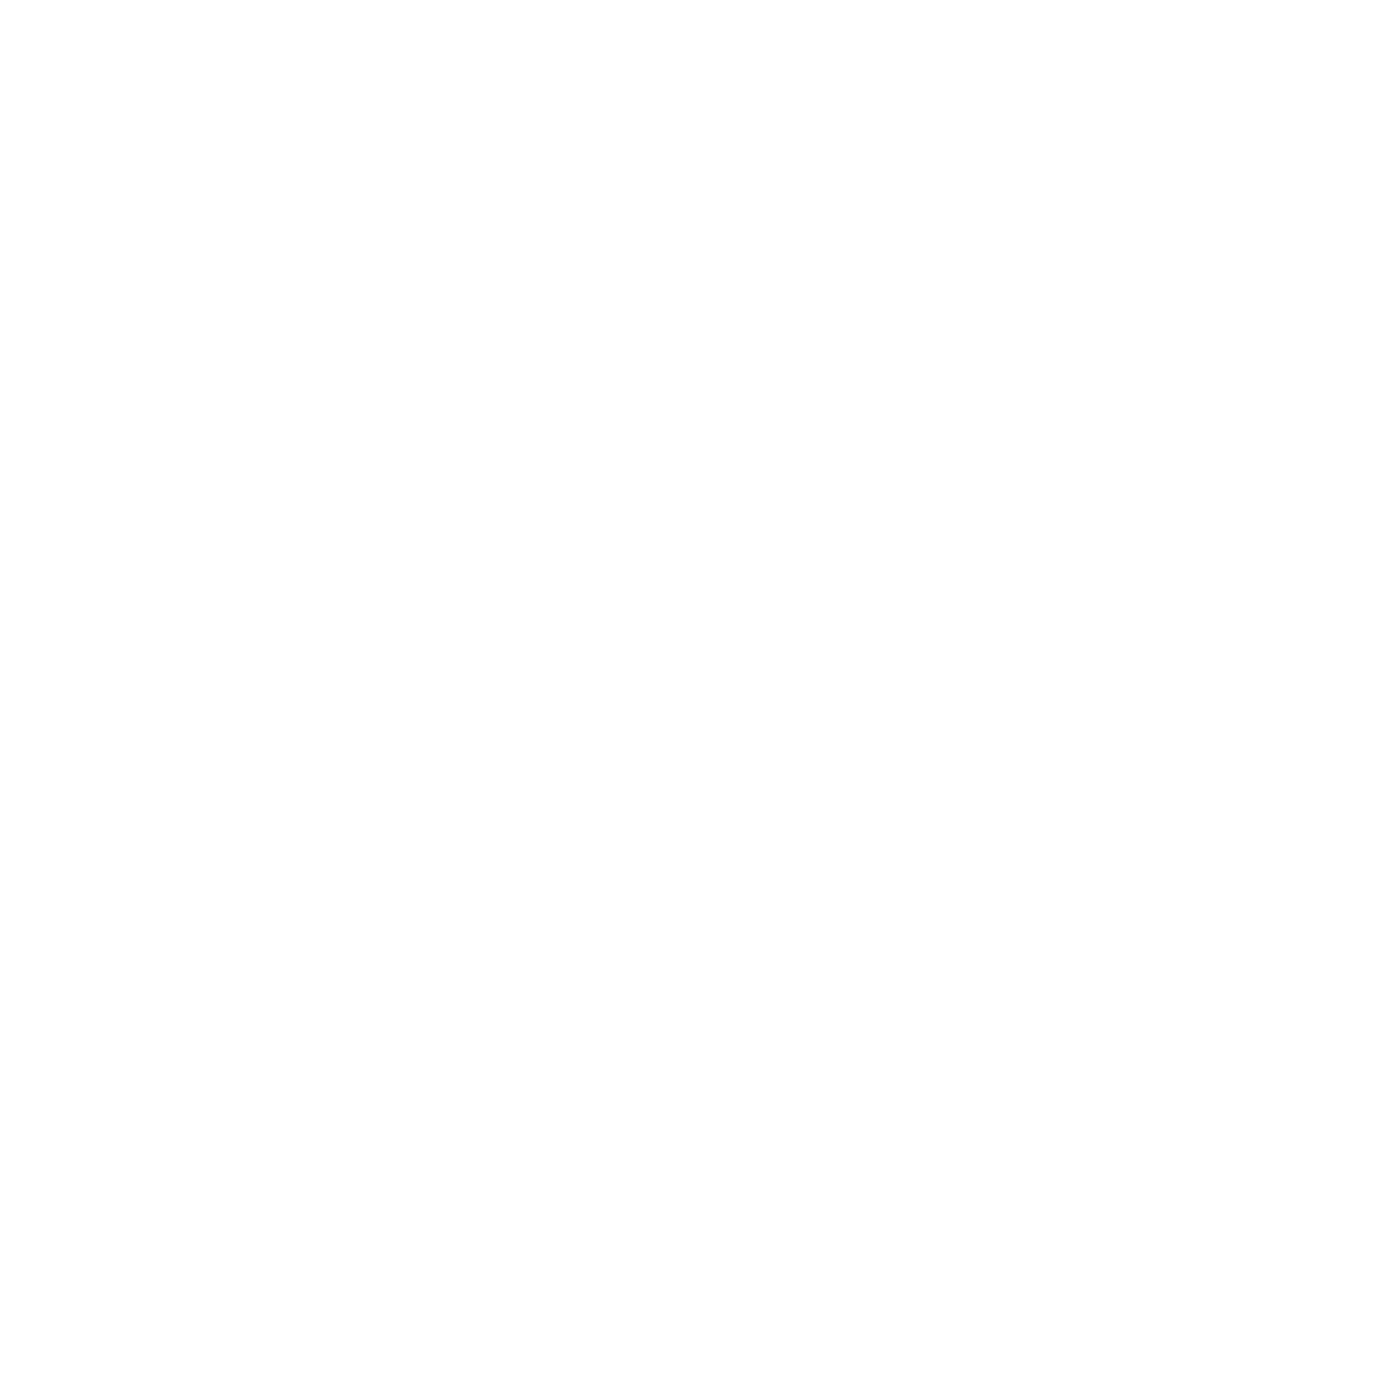

<IPython.core.display.Javascript object>


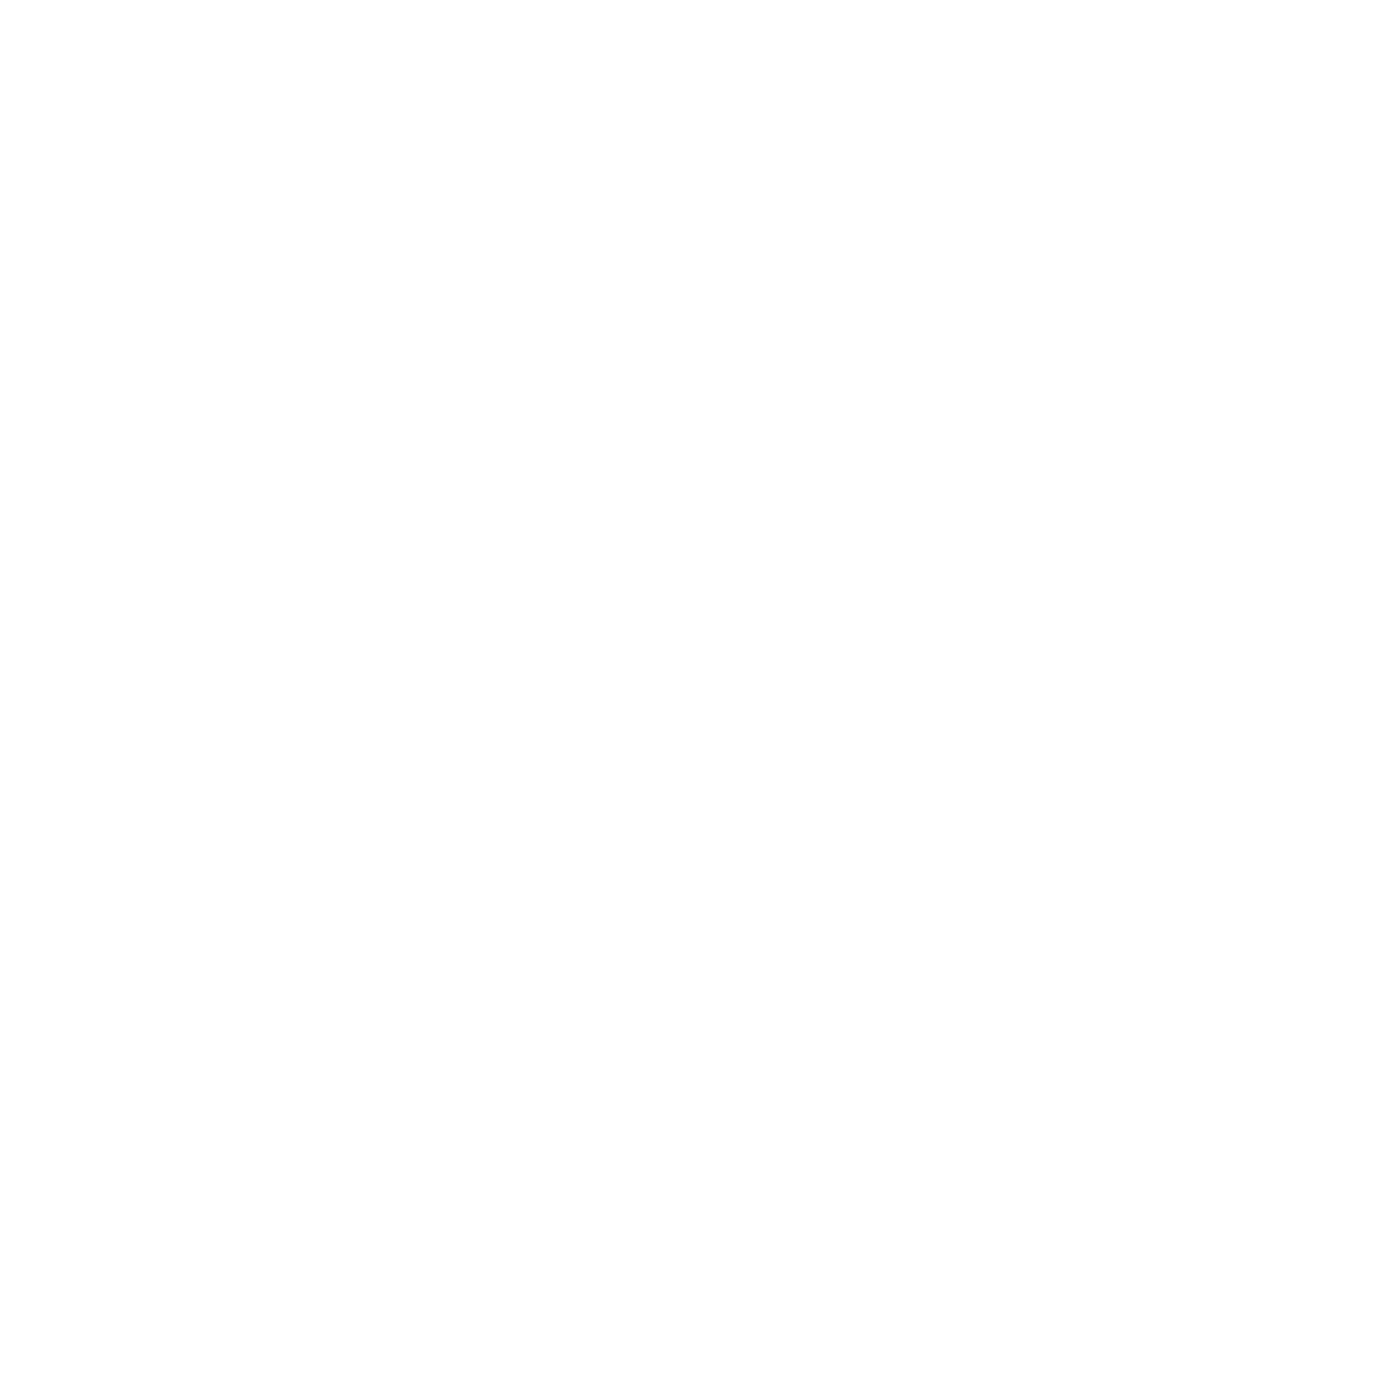

<IPython.core.display.Javascript object>


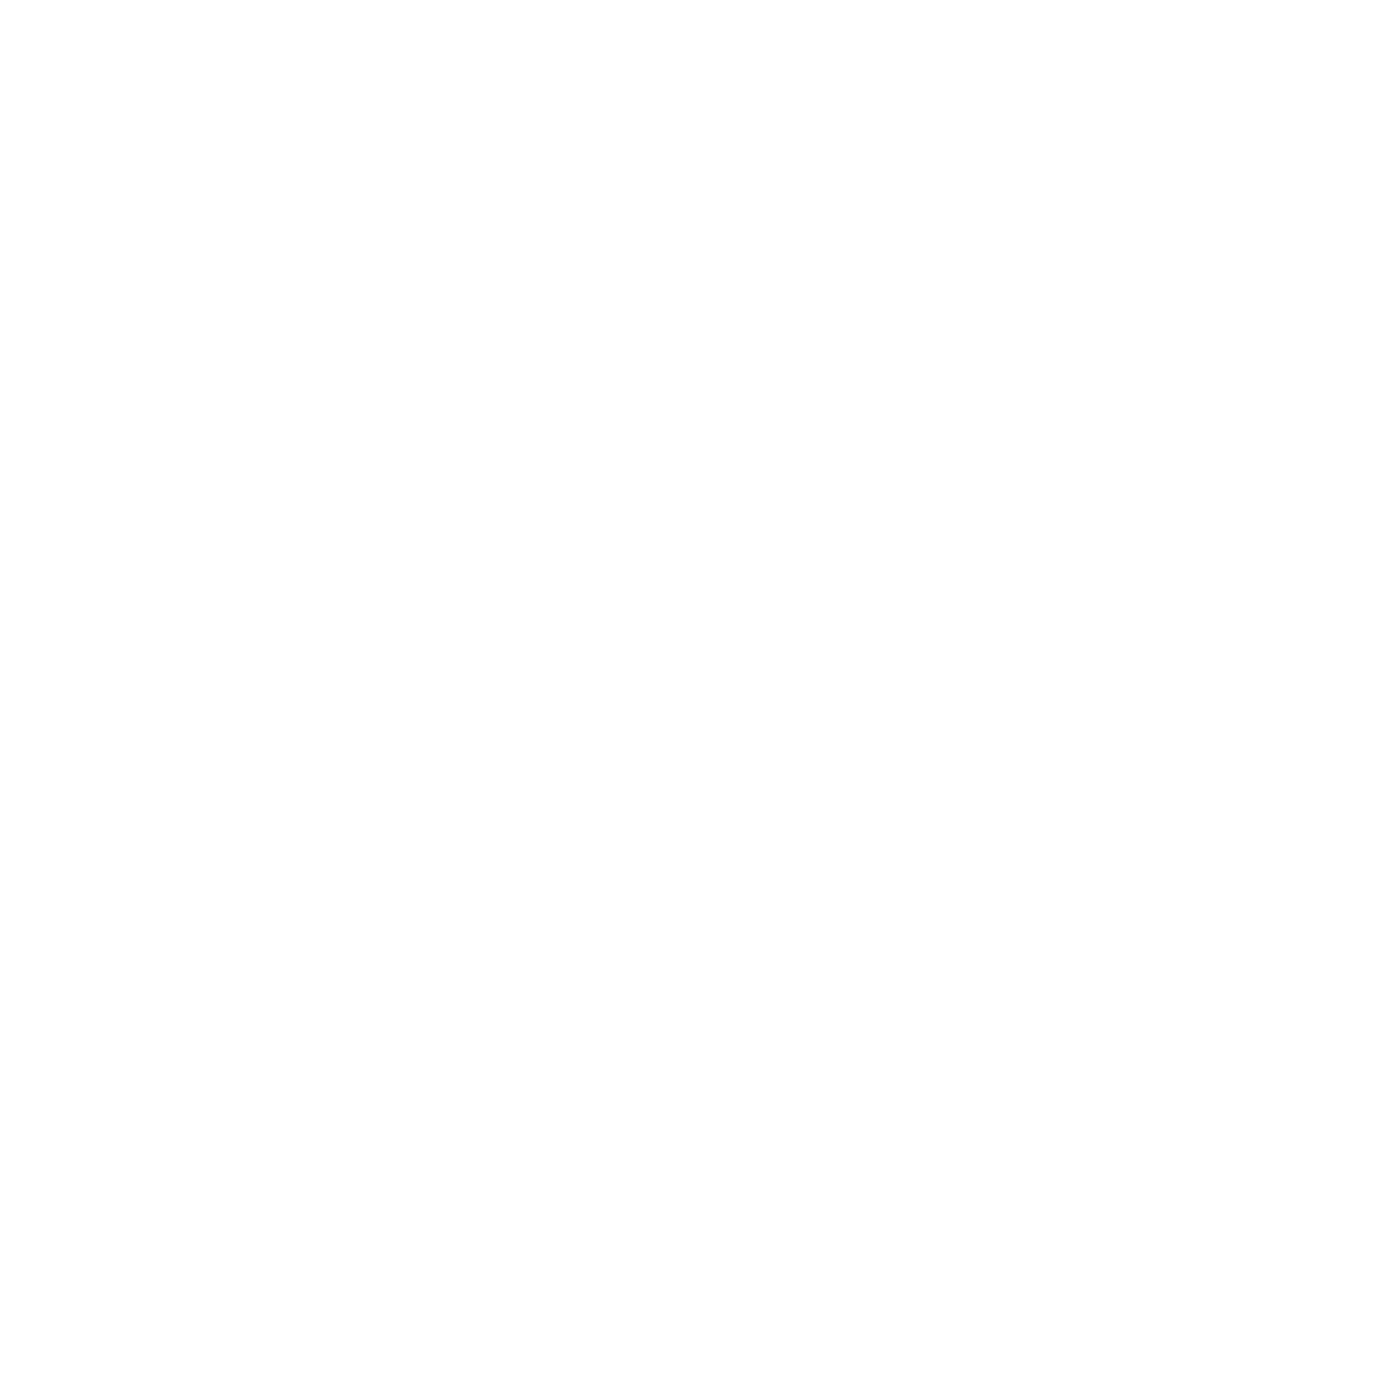

<IPython.core.display.Javascript object>


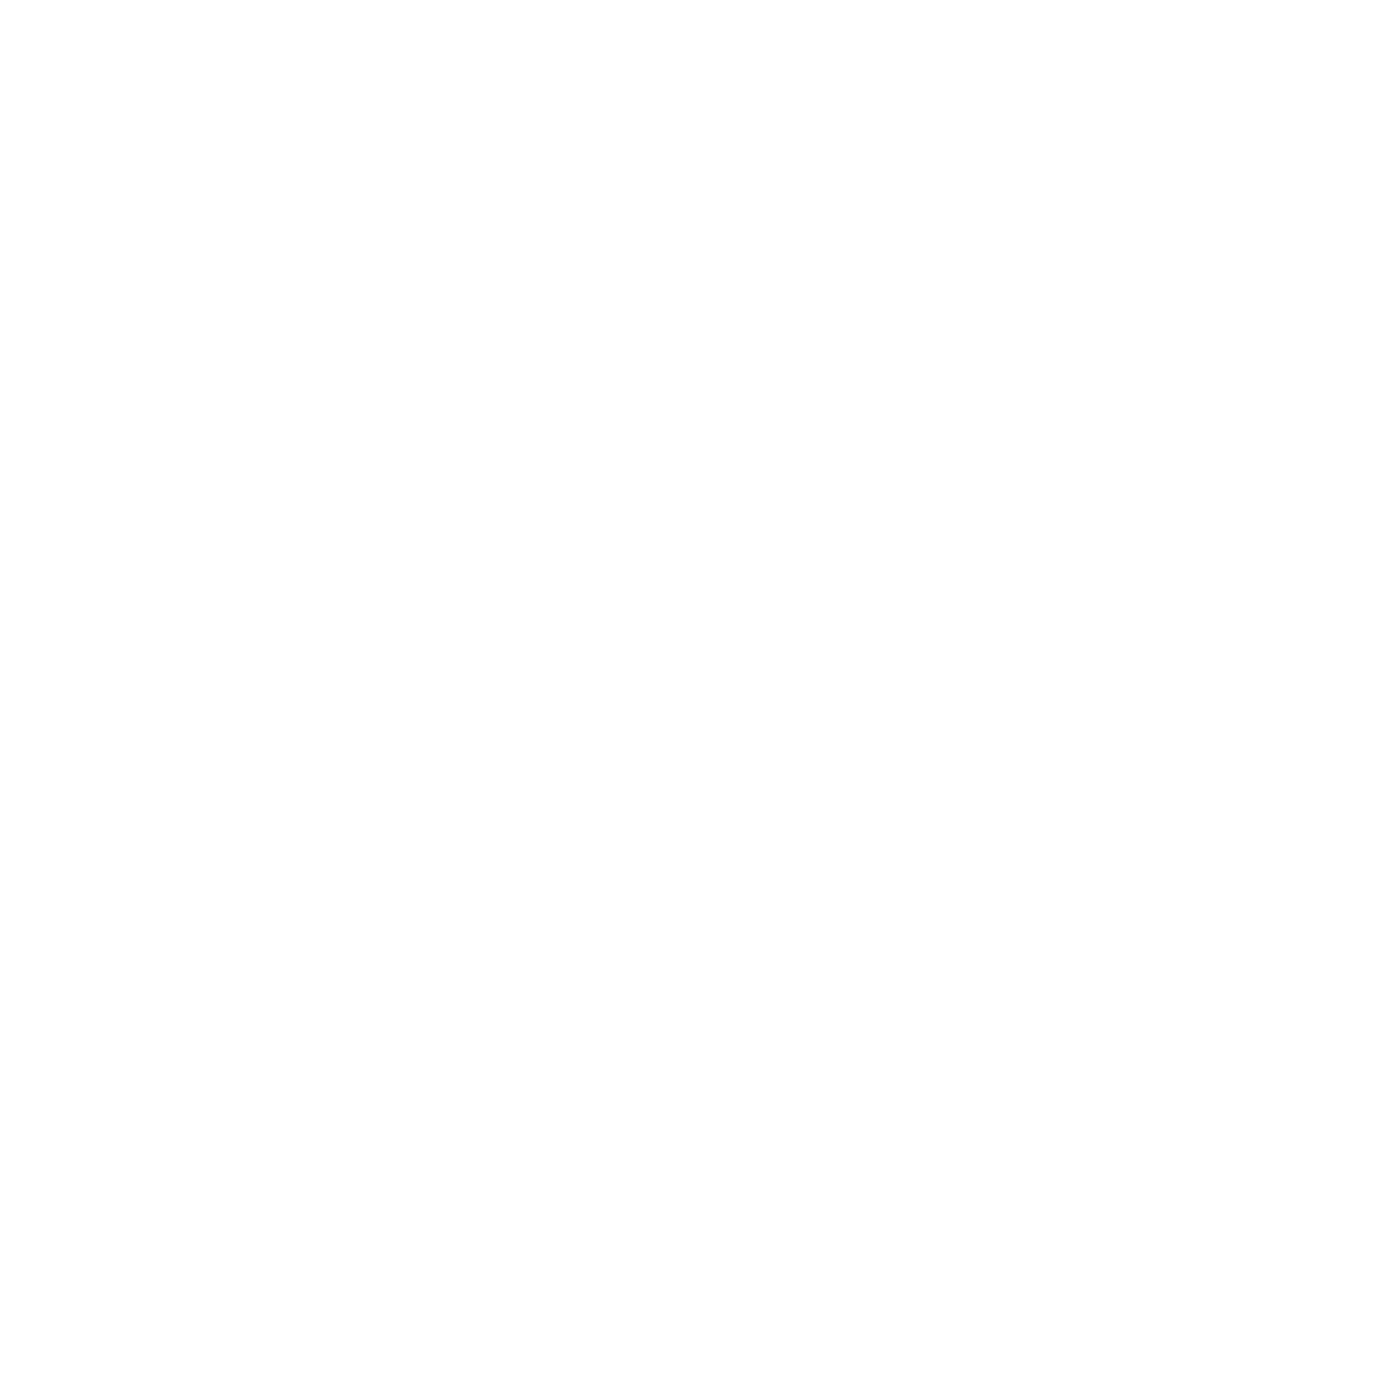

<IPython.core.display.Javascript object>


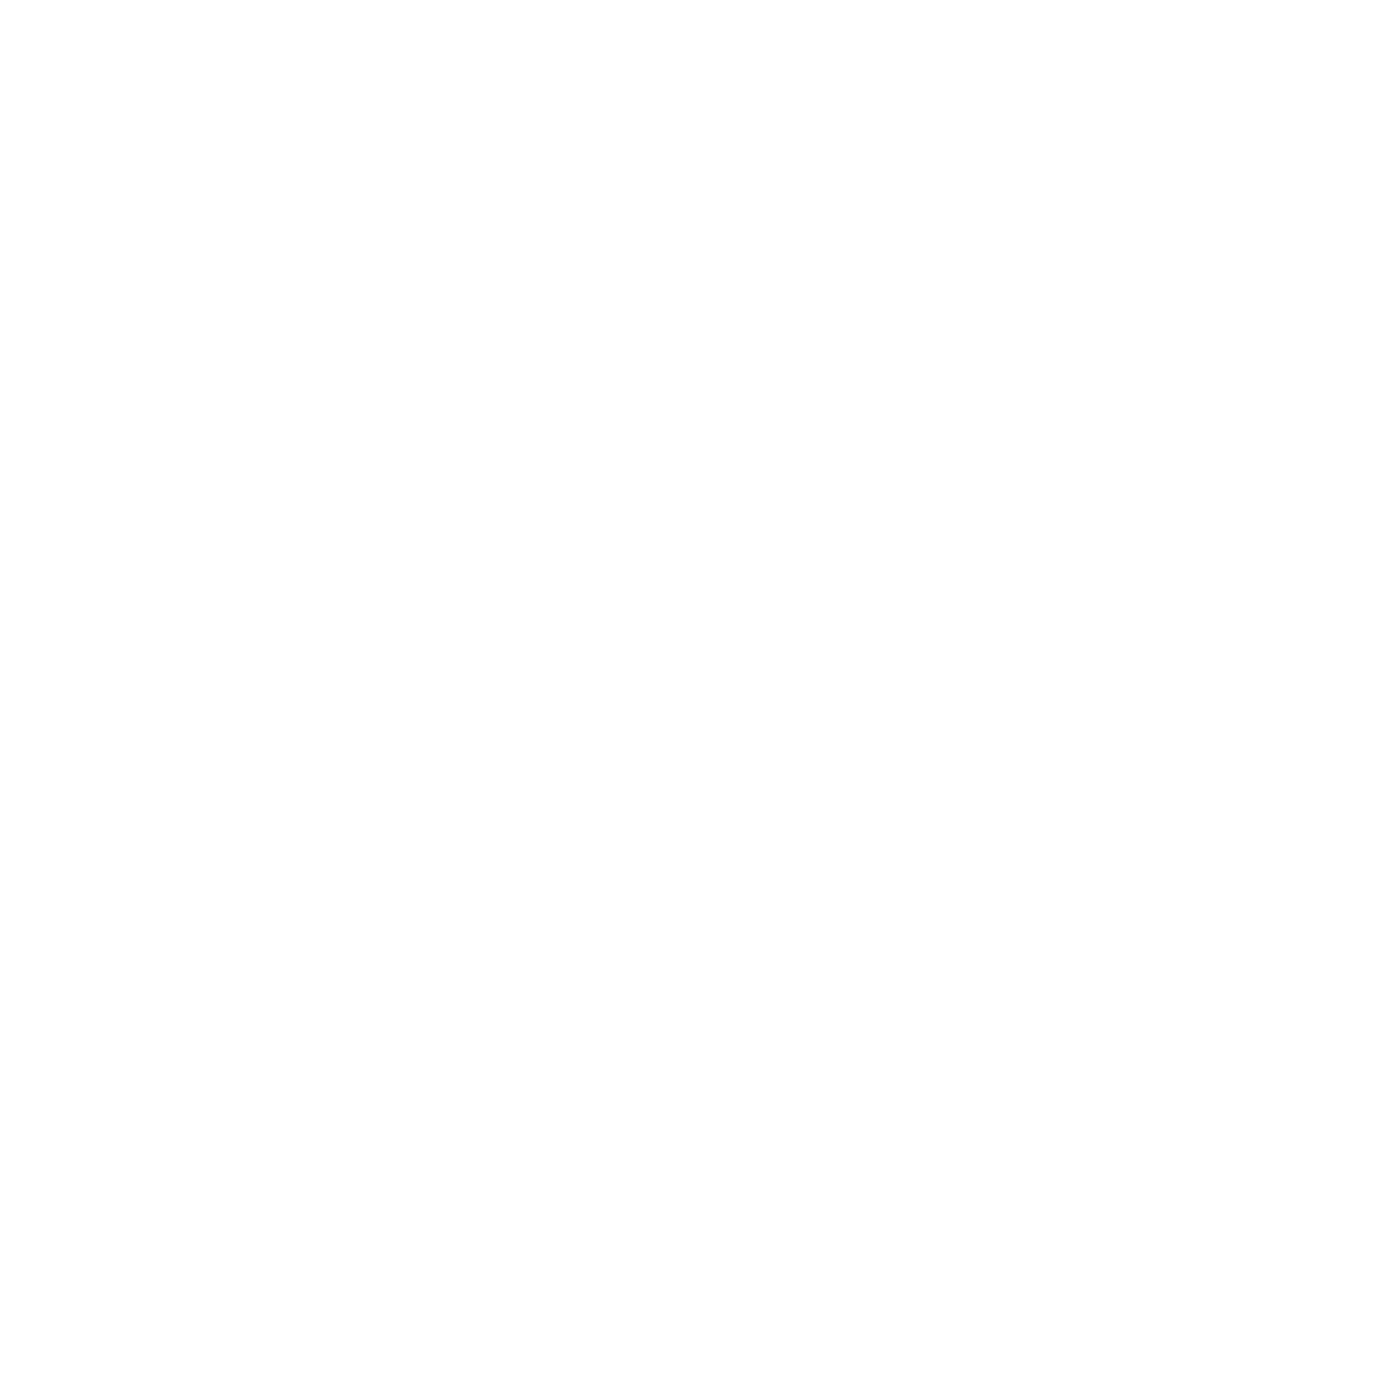

<IPython.core.display.Javascript object>


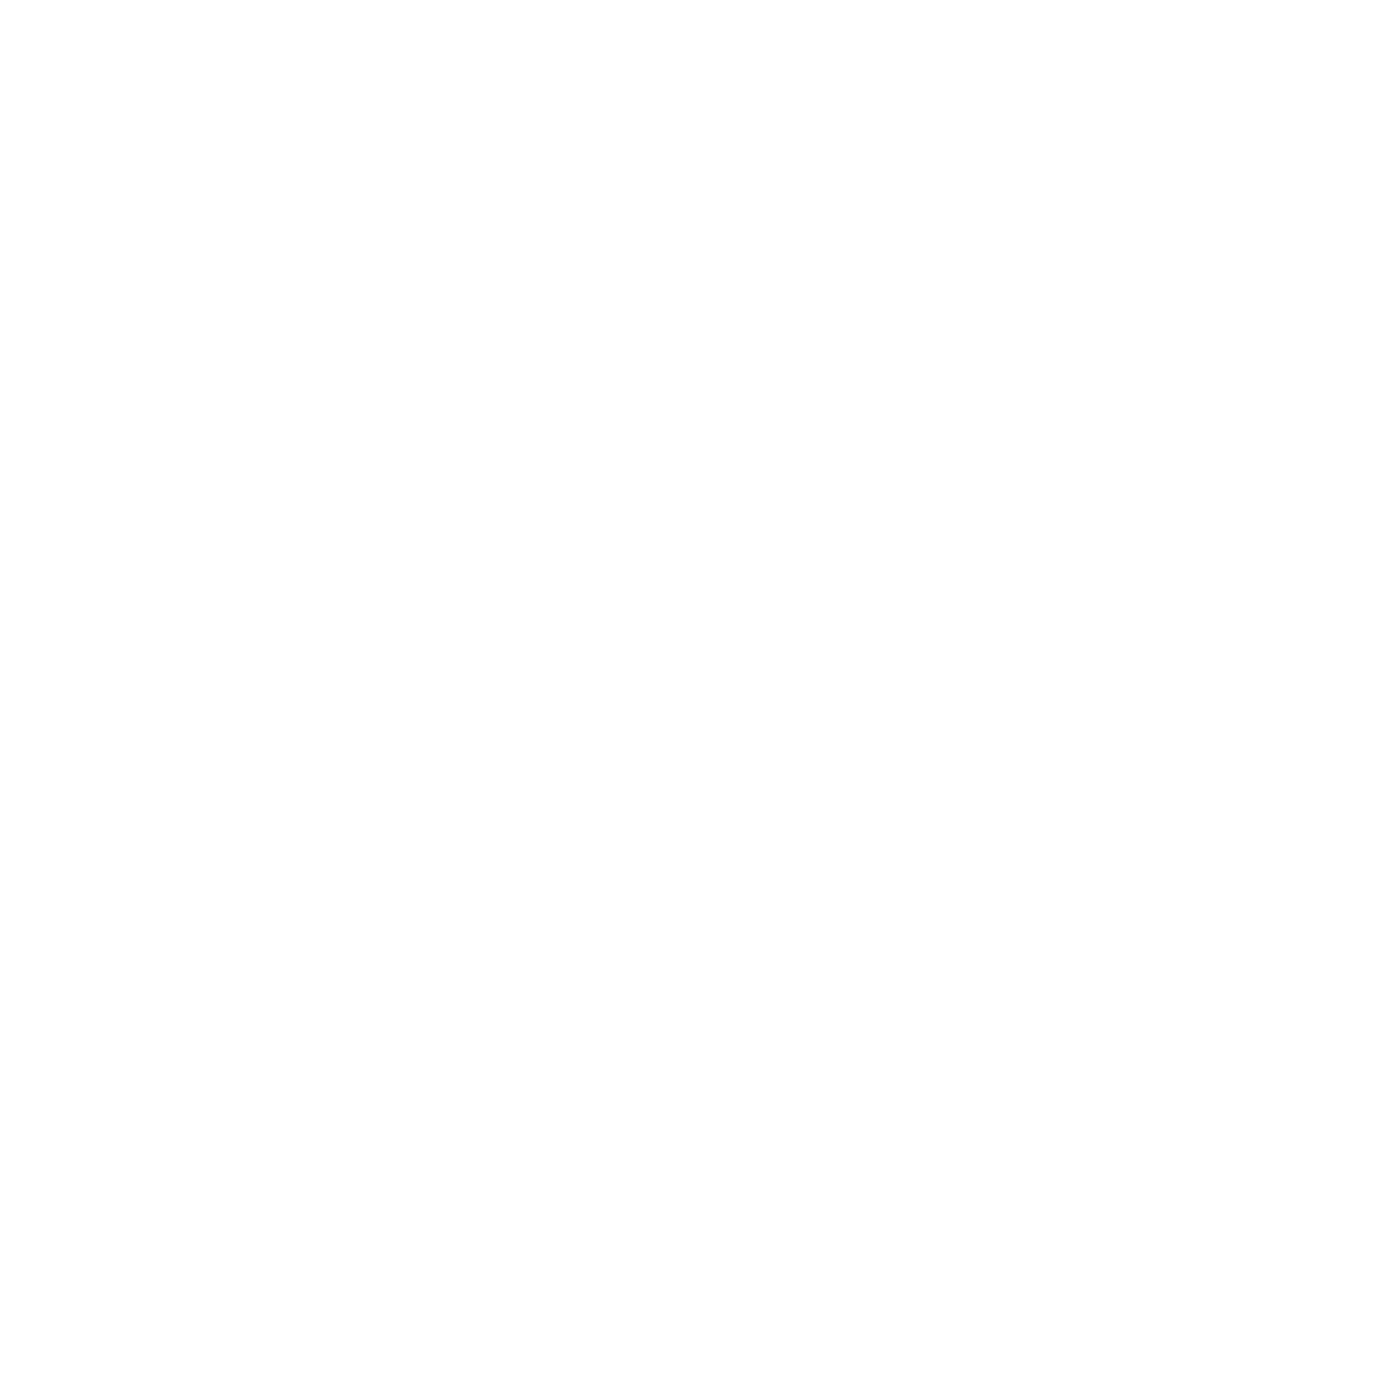

<IPython.core.display.Javascript object>


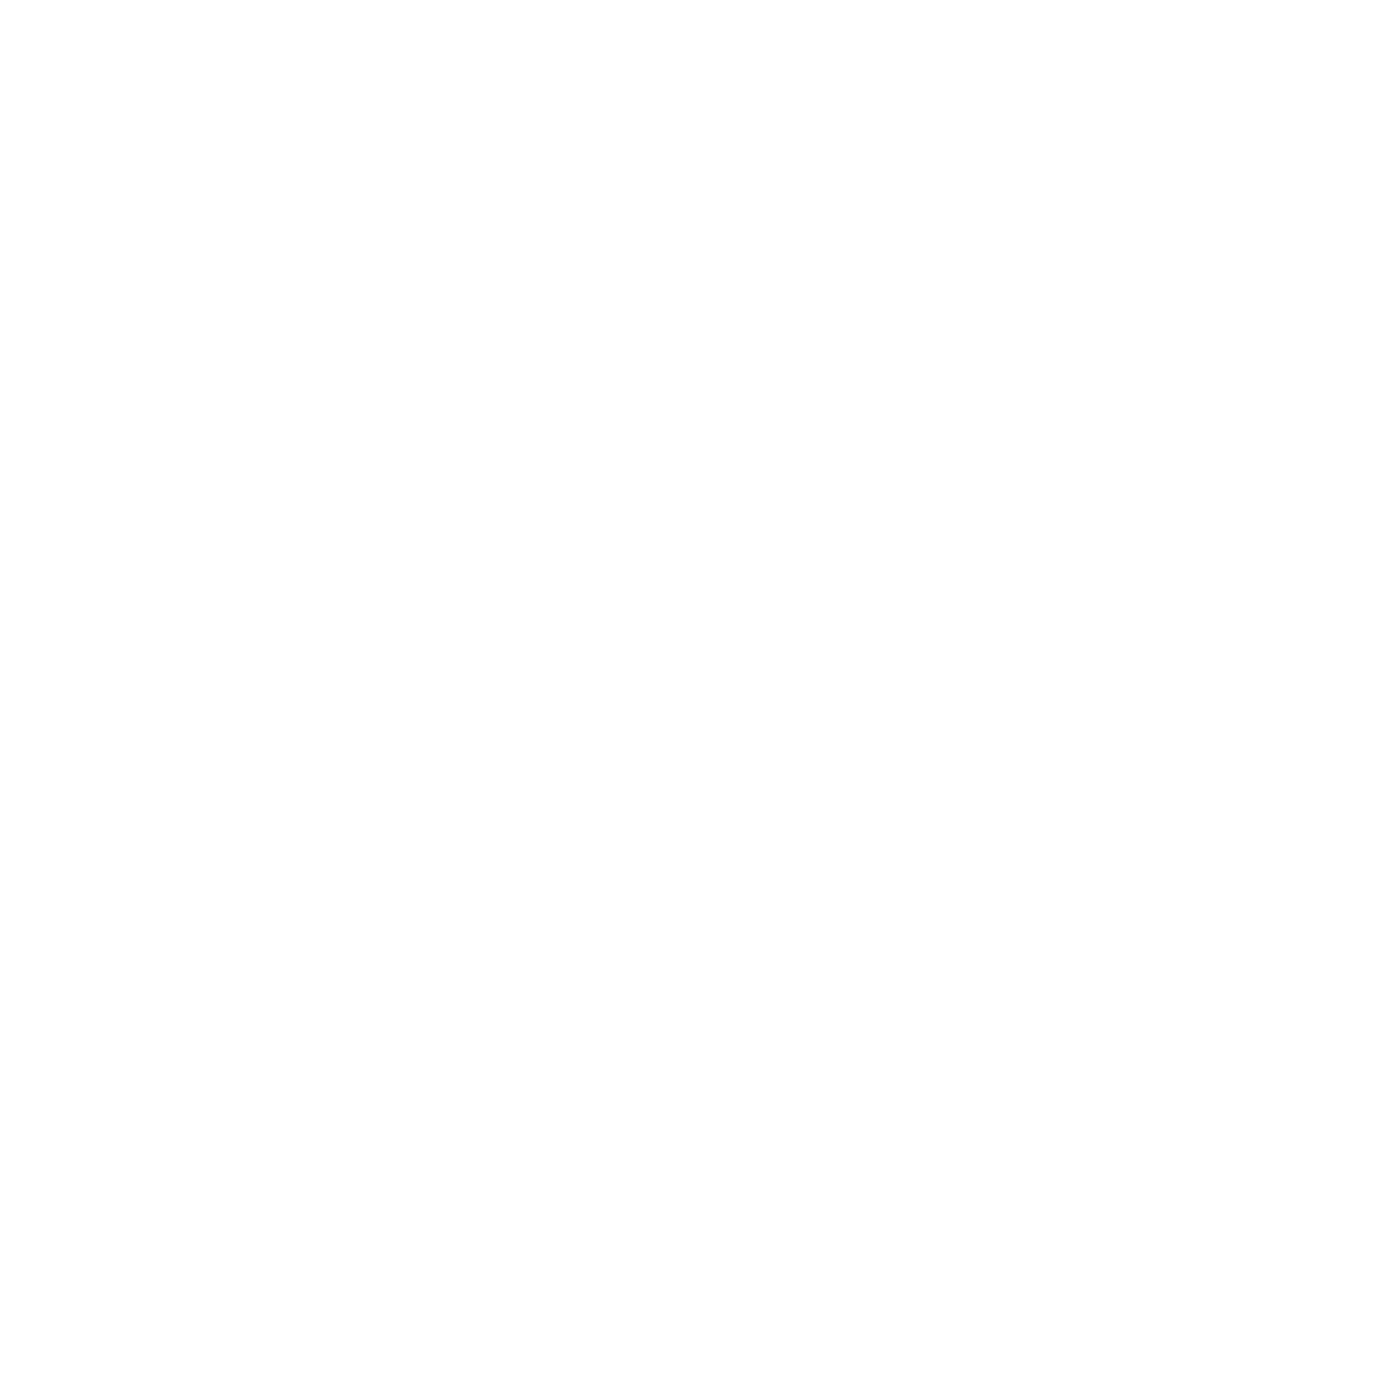

<IPython.core.display.Javascript object>


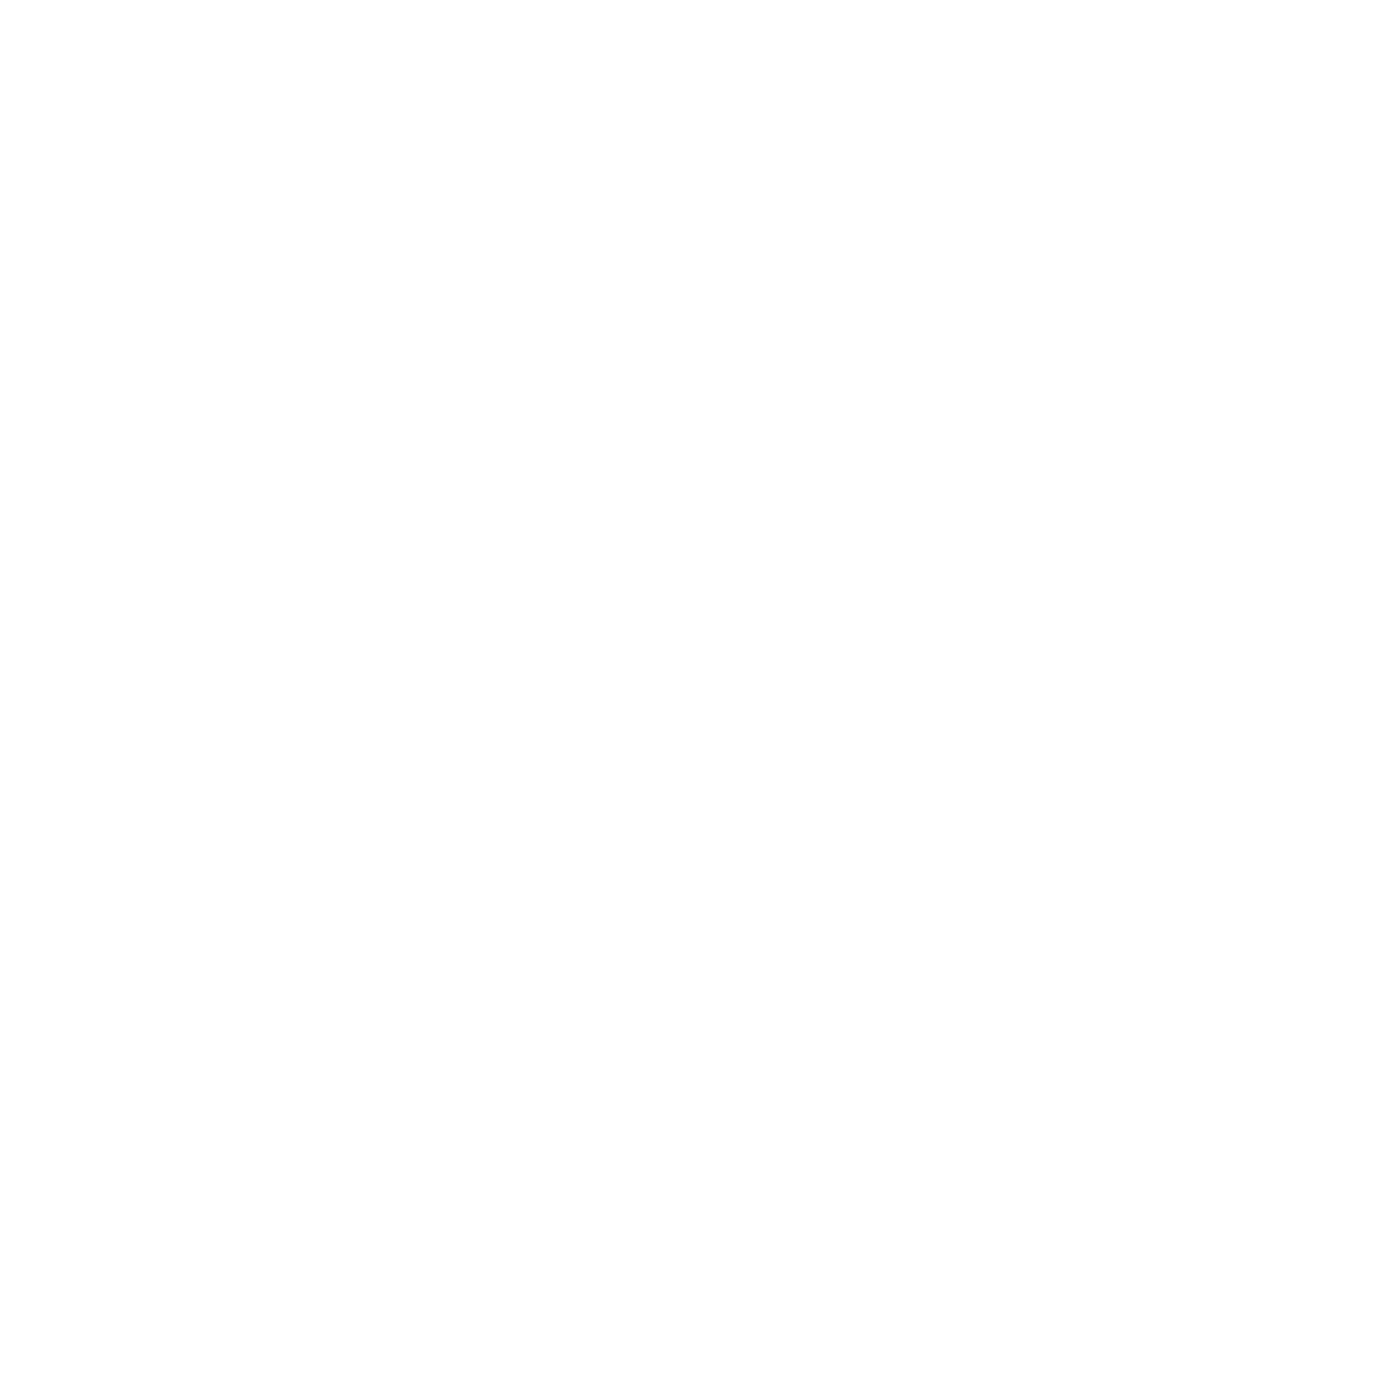

<IPython.core.display.Javascript object>


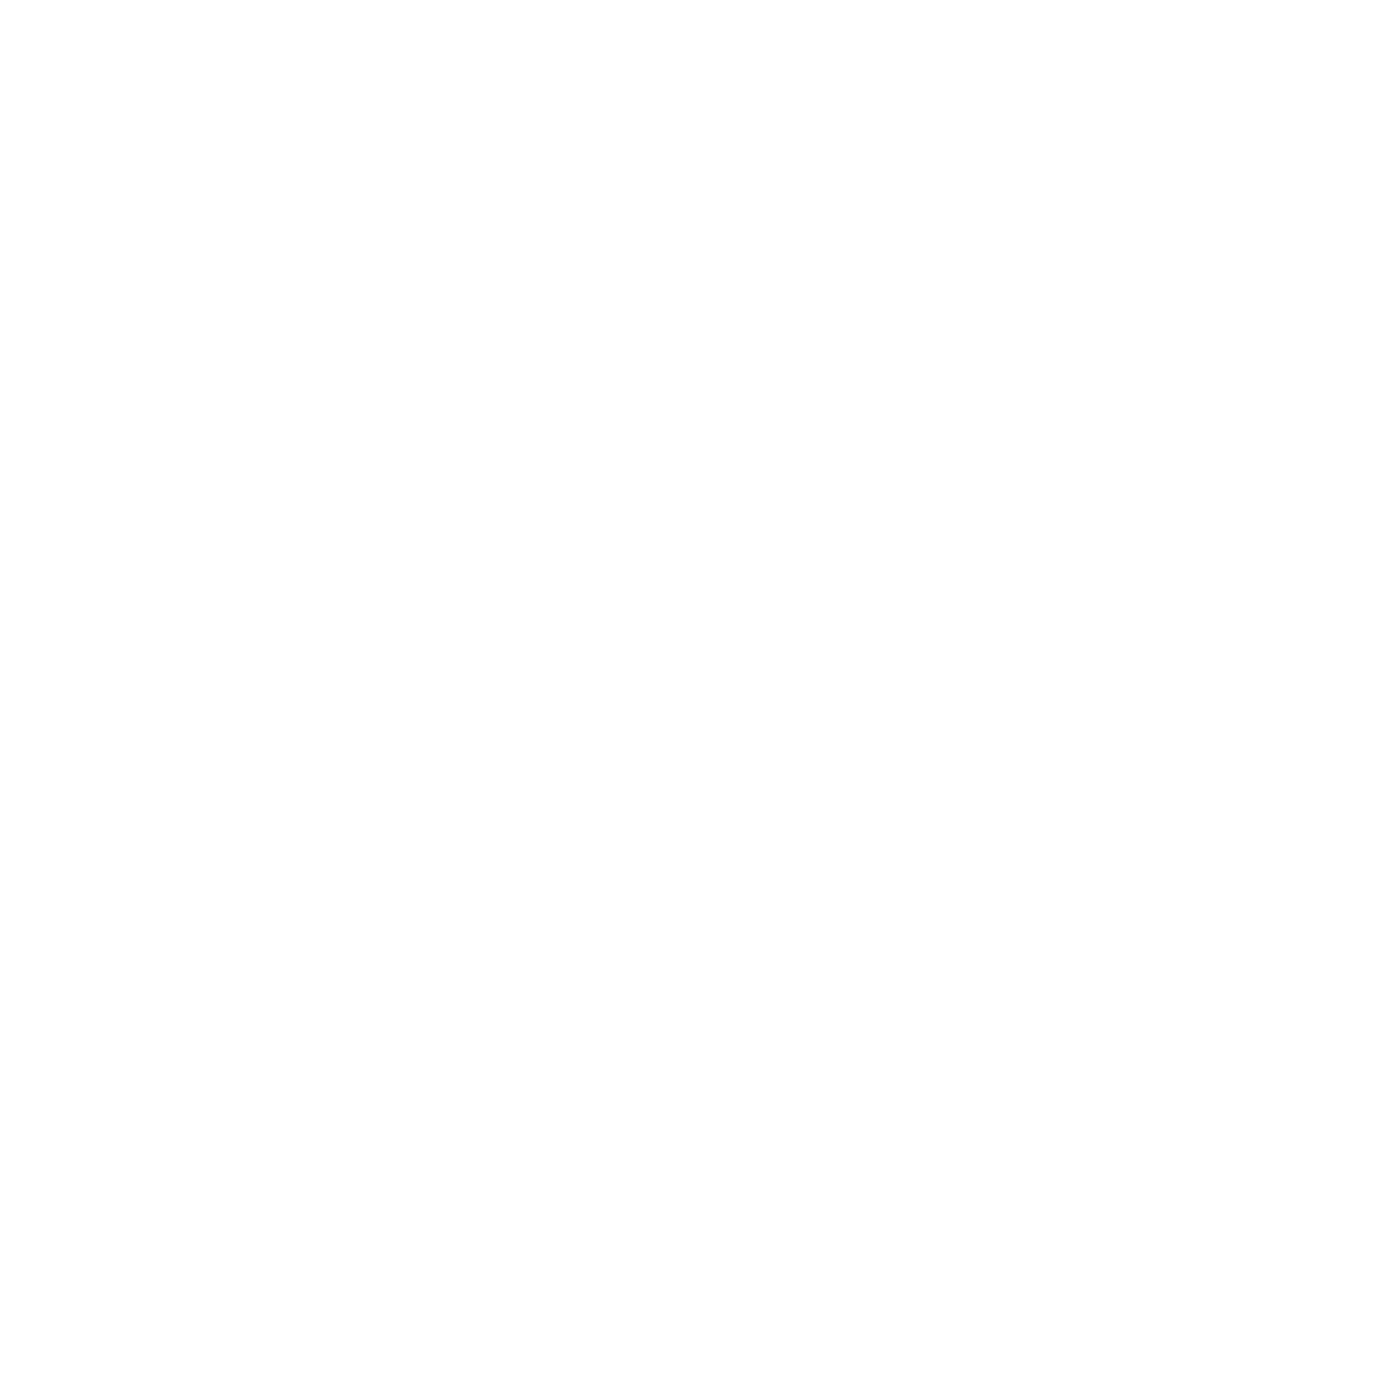

<IPython.core.display.Javascript object>


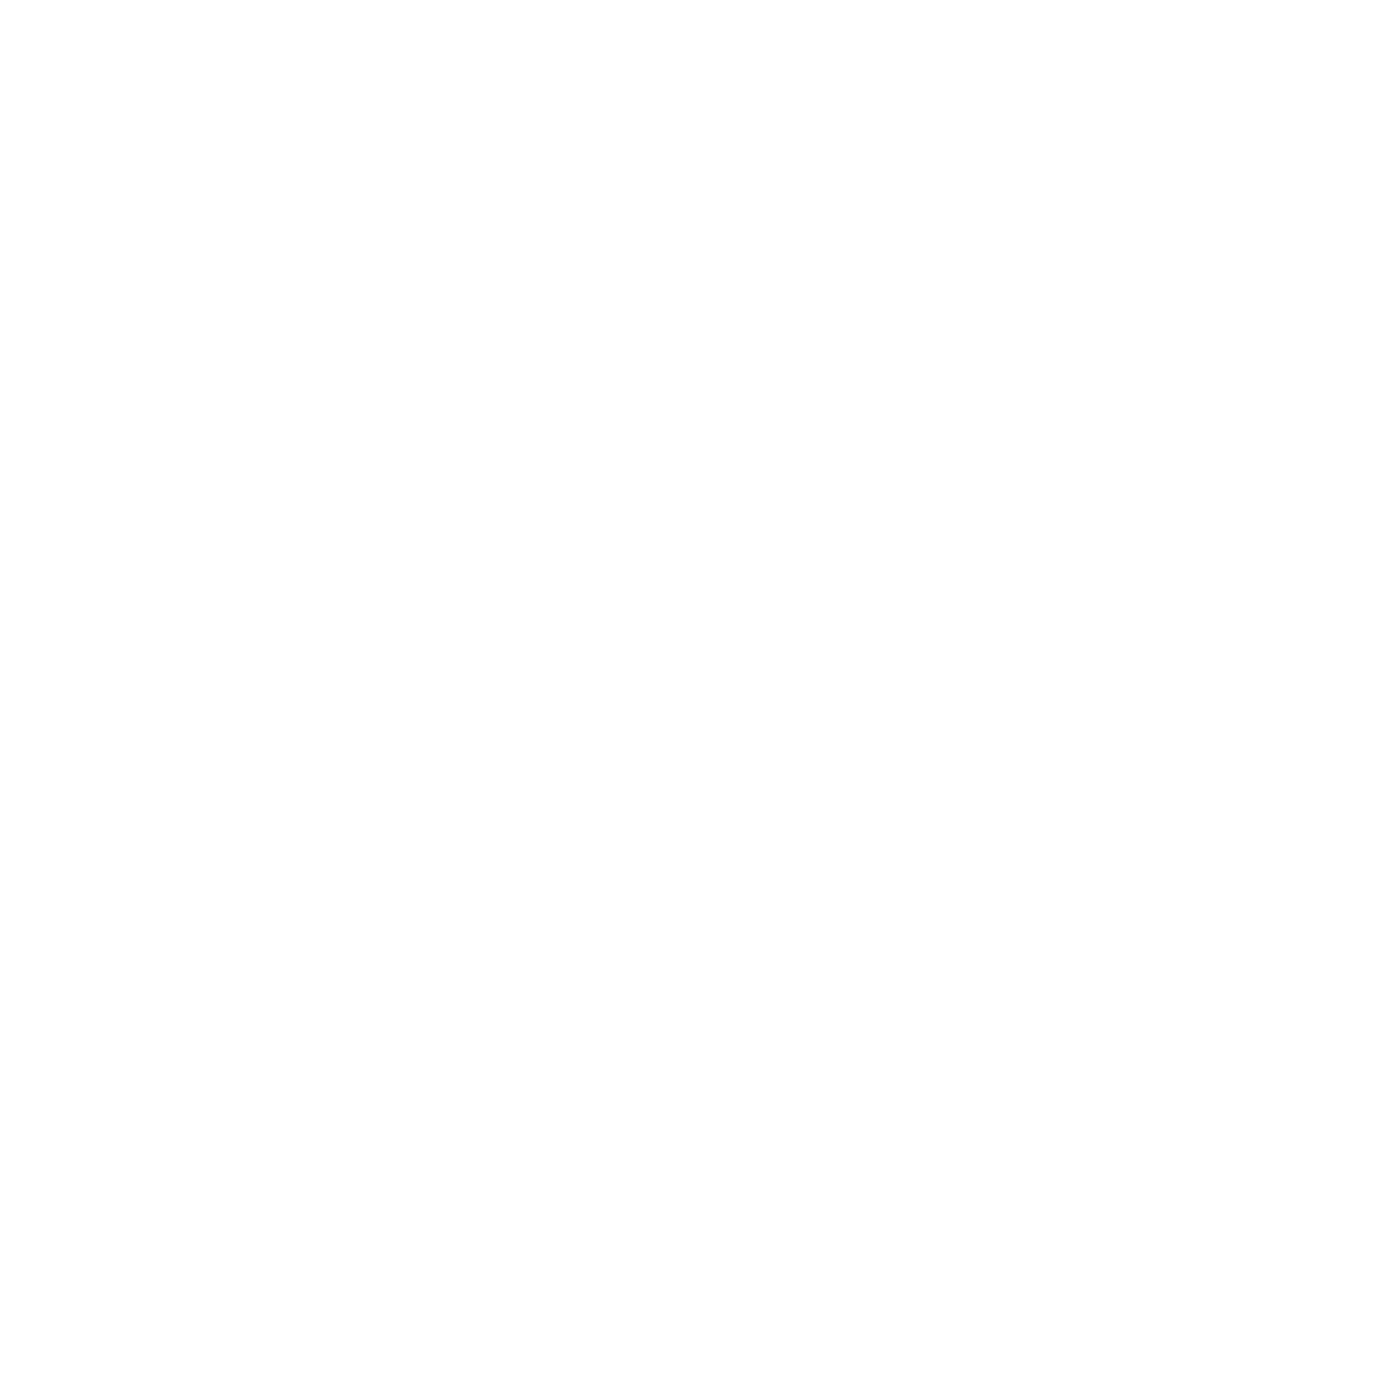

<IPython.core.display.Javascript object>


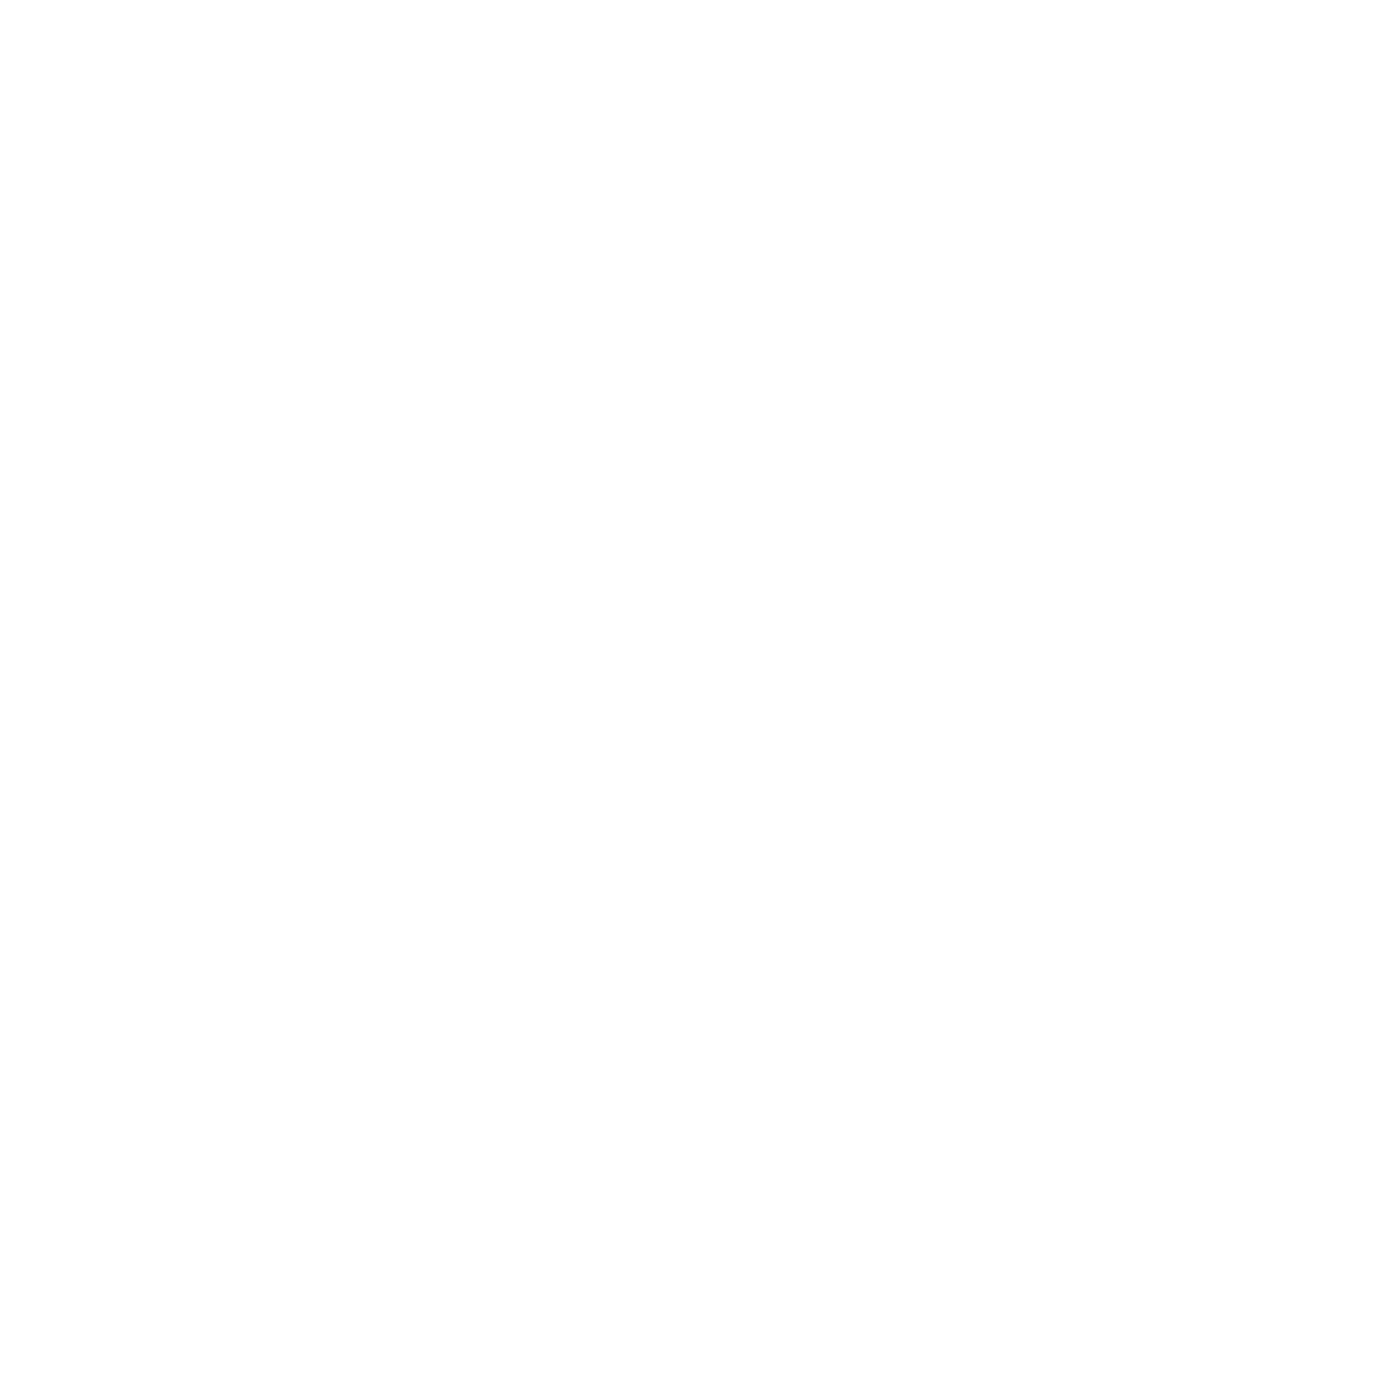

In [19]:
saveOutVectorMovementModel(sessionDict)


In [6]:
blNum = 2
trNumInBlock = 2

sessionDict['processedExp']['worldVidTimeSec'] = np.array(sessionDict['processedExp']['pupilTimestamp'] - sessionDict['processedExp']['pupilTimestamp'].iloc[0])
sessionDict['processedExp']['worldVidTimeSec'].tail(10)

trNumAbs = list(sessionDict['trialInfo'].groupby('blockNumber').get_group(blNum)['trialNumber'])

gbData_bl_tr = sessionDict['processedExp'].groupby(['blockNumber','trialNumber']) 
gbInfo_bl_tr = sessionDict['trialInfo'].groupby(['blockNumber','trialNumber']) 

trDataGb = gbData_bl_tr.get_group( (blNum,trNumAbs[trNumInBlock]) ) 
trInfoGb = gbInfo_bl_tr.get_group( (blNum,trNumAbs[trNumInBlock]) ) 


<IPython.core.display.Javascript object>


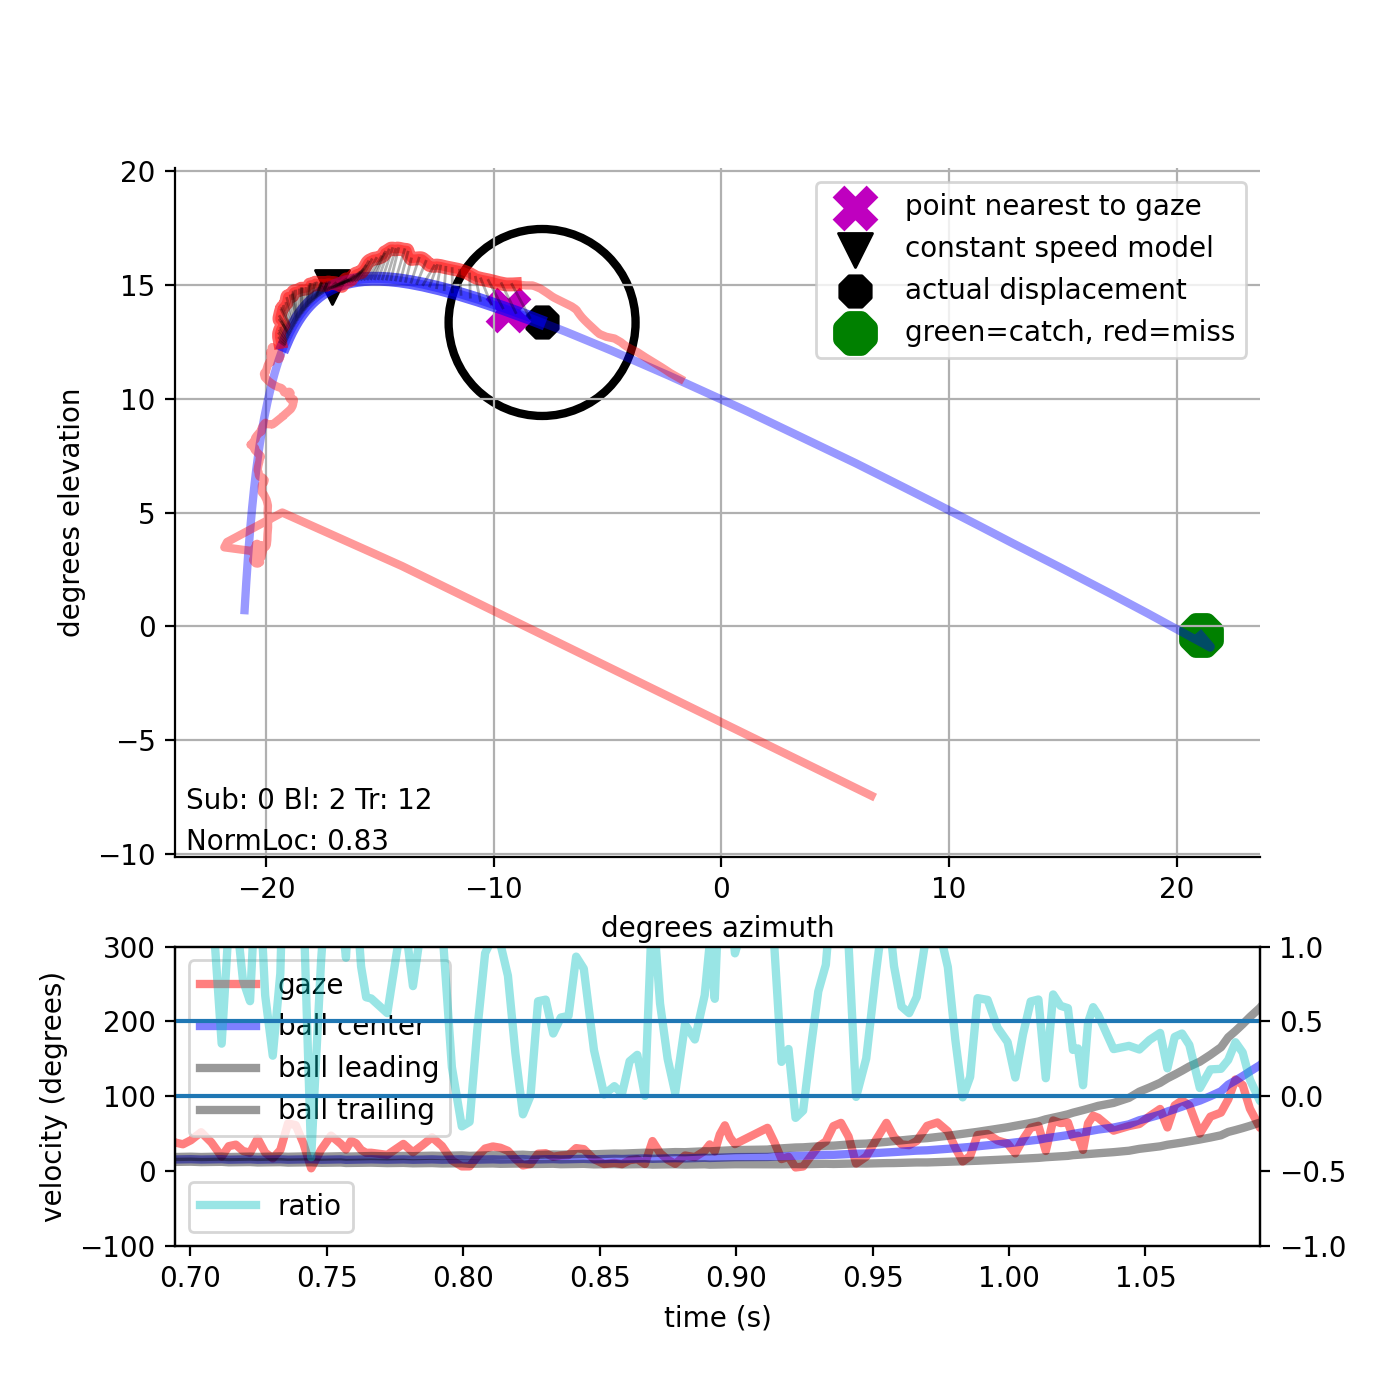

(<Figure size 700x700 with 3 Axes>,
 <AxesSubplot:xlabel='degrees azimuth', ylabel='degrees elevation'>)

In [7]:
plotMovementModel(trDataGb,
                  trInfoGb,
                  sessionDict['analysisParameters'],
                  halfHFOVDegs = 80,
                  figSize = [7,7])

In [8]:
df2 = trDataGb

startTimeS = trDataGb['worldVidTimeSec'].iloc[0]
endTimeS = trDataGb['worldVidTimeSec'].iloc[-2]

# I googled for, "python find first larger than"
startIndex = next(idx for idx, val in enumerate(df2['worldVidTimeSec']) if val >  startTimeS)
endIndex = next(idx for idx, val in enumerate(df2['worldVidTimeSec']) if val >  endTimeS)
print('Plotting from index: ' + str(startIndex) + ' to ' + str(endIndex))

colors_idx = ['rgb(0,204,204)','rgb(128,128,128)','rgb(204,0,0)','rgb(102,0,204)']

from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1,shared_xaxes=True)


tBall_el = go.Scattergl(
    x=df2['worldVidTimeSec'][startIndex:endIndex],
    y=df2['ball_el'][startIndex:endIndex],
    name = 'ball_el',
    marker_color = colors_idx[2],
    mode='markers',
    marker_size = 8,
    opacity = 0.5)

tBall_az = go.Scattergl(
    x=df2['worldVidTimeSec'][startIndex:endIndex],
    y=df2['ball_az'][startIndex:endIndex],
    name = 'ball_az',
    marker_color = colors_idx[3],
    mode='markers',
    marker_size = 8,
    opacity = 0.5)


tBall_Vel = go.Scattergl(

    x = df2['worldVidTimeSec'][startIndex:endIndex],
    y = df2['ballVel2D_fr'][startIndex:endIndex],
    name = 'ball velocity',
    marker_color = colors_idx[0],
    mode='markers',
    marker_size = 5,
    opacity = 1)



# eih_el = go.Scattergl(
#     x = df2['worldVidTimeSec'][startIndex:endIndex],
#     y = df2['cycGIW_el'][startIndex:endIndex],
#     name = 'cycGIW_el',
#     marker_color = colors_idx[0],
#     mode='markers',
#     marker_size = 5,
#     opacity = 1)

# eih_az = go.Scattergl(
#     x = df2['worldVidTimeSec'][startIndex:endIndex],
#     y = df2['cycGIW_az'][startIndex:endIndex],
#     name = 'cycGIW_az',
#     marker_color = colors_idx[1],
#     mode='markers',
#     marker_size = 5,
#     opacity = 1)



####


fig.append_trace(tBall_el, row=1, col=1)
fig.append_trace(tBall_az, row=1, col=1)
# fig.append_trace(eih_el, row=1, col=1)
# fig.append_trace(eih_az, row=1, col=1)

# fig.append_trace(vel, row=2, col=1)
fig.append_trace(tBall_Vel, row=2, col=1)



yLim=[-50,50]
width=800
height=800
inline=True

layout = dict(
    dragmode= 'pan',
    title='Time Series with Rangeslider',
    width=width,
    height=height,
    yaxis=dict(range=yLim, title='angular position (degrees)'),
)

fig.update_yaxes(range=[-30, 80], row=1, col=1)
fig.update_yaxes(range=[0, 200], row=2, col=1)

# fig.update_xaxes(range=[startTimeS,startTimeS+0.5], row=2, col=1)

fig.update_yaxes(title = 'por (deg)',row=1,col=1)
fig.update_yaxes(title = 'vel (deg/s)',row=2,col=1)
fig.update_xaxes(title = 'time (s)',row=3,col=1)

fig.update_layout(legend_orientation="h", 
             xaxis2_rangeslider_visible=True, xaxis2_rangeslider_thickness=0.1,
                  xaxis2_rangeslider_range=[startTimeS,startTimeS+0.5])

fig.update_layout(height=height, width=width, title_text="Stacked Subplots")

iplot(fig)


Plotting from index: 1 to 662


In [9]:
list(sessionDict['processedExp'])
x = np.arange(0,len(sessionDict['processedExp']))
y = sessionDict['processedExp']['frameTime']
plt.scatter(x,y)